In [55]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_log_error
from tensorflow.keras.models import load_model

In [56]:
df = pd.read_csv(r'/home/long/longdata/kaggle compe/dataset/num_df.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   pickup_longitude   1458644 non-null  float64
 1   pickup_latitude    1458644 non-null  float64
 2   dropoff_longitude  1458644 non-null  float64
 3   dropoff_latitude   1458644 non-null  float64
 4   trip_duration      1458644 non-null  int64  
 5   haversine_km       1458644 non-null  float64
 6   bearing            1458644 non-null  float64
 7   is_zero_distance   1458644 non-null  bool   
 8   pickup_cluster     1458644 non-null  int64  
 9   dropoff_cluster    1458644 non-null  int64  
dtypes: bool(1), float64(6), int64(3)
memory usage: 101.5 MB


In [57]:
x = df.drop('trip_duration', axis=1)
y = df['trip_duration']
print(x.columns)

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'haversine_km', 'bearing', 'is_zero_distance',
       'pickup_cluster', 'dropoff_cluster'],
      dtype='object')


In [58]:
df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,haversine_km,bearing,is_zero_distance,pickup_cluster,dropoff_cluster
0,-73.982155,40.767937,-73.964630,40.765602,455,1.498521,99.970196,False,0,8
1,-73.980415,40.738564,-73.999481,40.731152,663,1.805507,242.846232,False,0,9
2,-73.979027,40.763939,-74.005333,40.710087,2124,6.385098,200.319835,False,0,9
3,-74.010040,40.719971,-74.012268,40.706718,429,1.485498,187.262300,False,4,9
4,-73.973053,40.793209,-73.972923,40.782520,435,1.188588,179.473585,False,3,8


In [59]:
def rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.clip_by_value(y_true, 1e-7, tf.reduce_max(y_true))
    y_pred = tf.clip_by_value(y_pred, 1e-7, tf.reduce_max(y_pred))
    log_true = tf.math.log(y_true + 1.0)
    log_pred = tf.math.log(y_pred + 1.0)
    return tf.sqrt(tf.reduce_mean(tf.square(log_pred - log_true)))

In [60]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [61]:
model = keras.Sequential([
    layers.Input(shape=(x_scaled.shape[1],)), 

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),

    layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=rmsle,
    metrics=[rmsle]
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [64]:
history = model.fit(
    x_scaled, y,
    validation_split=0.01,
    epochs=100,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
5641/5641 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 1.1034 - rmsle: 1.1034 - val_loss: 0.5035 - val_rmsle: 0.5035
Epoch 2/100
5641/5641 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.4913 - rmsle: 0.4913 - val_loss: 0.4668 - val_rmsle: 0.4668
Epoch 3/100
5641/5641 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.4785 - rmsle: 0.4785 - val_loss: 0.4733 - val_rmsle: 0.4732
Epoch 4/100
5641/5641 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.4761 - rmsle: 0.4761 - val_loss: 0.4894 - val_rmsle: 0.4894
Epoch 5/100
5641/5641 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.4751 - rmsle: 0.4751 - val_loss: 0.4605 - val_rmsle: 0.4605
Epoch 6/100
5641/5641 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.4725 - rmsle: 0.4725 - val_loss: 0.4537 - val_rmsle: 0.4536
Epoch 7/100
5641/5641 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.4698 - rmsle: 0.4698 - val_loss: 0.4920 - val_rmsle: 0.4919
Epoch 8/100
5641/5641 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.4684 - rmsle: 0.4684 - val_loss: 0.4629 - val_rmsle:

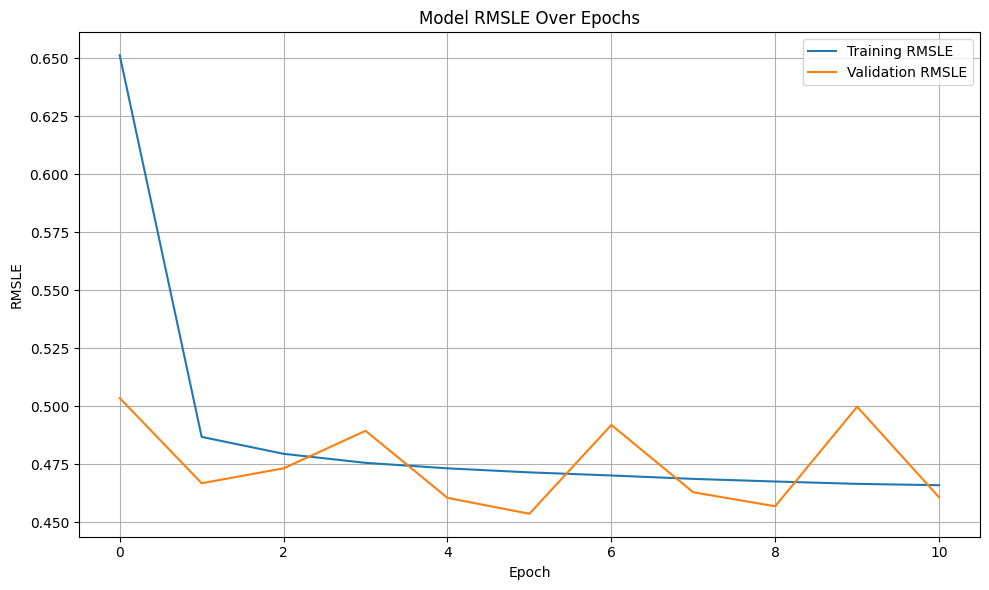

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training RMSLE')
plt.plot(history.history['val_loss'], label='Validation RMSLE')
plt.title('Model RMSLE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSLE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
model.save('nn.keras')

In [67]:
test_df = pd.read_csv(r'/home/long/longdata/kaggle compe/dataset/test.csv')
df = pd.read_csv(r'/home/long/longdata/kaggle compe/dataset/num_df.csv')
scaler = StandardScaler()
test_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [69]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371 
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

def bearing(lat1, lon1, lat2, lon2):
    dLon = np.radians(lon2 - lon1)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    x = np.sin(dLon) * np.cos(lat2)
    y = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees(np.arctan2(x, y)) + 360) % 360

test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'])
test_df['haversine_km'] = haversine(test_df['pickup_latitude'], test_df['pickup_longitude'],
                                    test_df['dropoff_latitude'], test_df['dropoff_longitude'])
test_df['bearing'] = bearing(test_df['pickup_latitude'], test_df['pickup_longitude'],
                             test_df['dropoff_latitude'], test_df['dropoff_longitude'])
test_df['is_zero_distance'] = test_df['haversine_km'] < 0.01
pickup_coords = df[['pickup_latitude', 'pickup_longitude']].dropna()
dropoff_coords = df[['dropoff_latitude', 'dropoff_longitude']].dropna()

pickup_kmeans = KMeans(n_clusters=10, random_state=42).fit(pickup_coords)
dropoff_kmeans = KMeans(n_clusters=10, random_state=42).fit(dropoff_coords)

test_df['pickup_cluster'] = pickup_kmeans.predict(test_df[['pickup_latitude', 'pickup_longitude']])
test_df['dropoff_cluster'] = dropoff_kmeans.predict(test_df[['dropoff_latitude', 'dropoff_longitude']])

In [70]:
test_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,haversine_km,bearing,is_zero_distance,pickup_cluster,dropoff_cluster
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,2.746426,356.404776,False,4,0
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,2.759239,172.278835,False,4,5
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,1.306155,133.326248,False,4,9
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,5.269088,209.043167,False,3,9
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,0.960842,130.260381,False,0,0


In [ ]:
features = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'haversine_km', 'bearing', 'pickup_cluster', 'dropoff_cluster', 'is_zero_distance']
scaler = StandardScaler()
scaler.fit(df[features])  

x_test_scaled = scaler.transform(test_df[features])  
def rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.clip_by_value(y_true, 1e-7, tf.reduce_max(y_true))
    y_pred = tf.clip_by_value(y_pred, 1e-7, tf.reduce_max(y_pred))
    log_true = tf.math.log(y_true + 1.0)
    log_pred = tf.math.log(y_pred + 1.0)
    return tf.sqrt(tf.reduce_mean(tf.square(log_pred - log_true)))

model = load_model(
    r'/home/long/longdata/kaggle compe/nyc-taxi-trip-duration/bully-maguire.keras',
    custom_objects={'rmsle': rmsle}
)
y_pred = model.predict(x_test_scaled)

test_predictions = pd.DataFrame({'trip_duration': y_pred.flatten()})
test_predictions.to_csv('test_pred.csv', index=False)

19536/19536 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step
